# Land Use Change

In [48]:
# our land use change estimate

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from project_config import get_config

cfg = get_config()
luc_folder = cfg.paths.luc_analysis

In [ ]:
luc_estimates_yearly = []
luc_estimate_total = None

cleared_forest_col = 'cleared_forest'
ever_cleared_col = 'ever_cleared_forest'
difference_cleared_col = 'cleared_difference'
difference_ever_cleared_col = 'ever_cleared_difference'

luc_data = pd.read_csv(luc_folder + '/luc_timeseries.csv', parse_dates=['date'])

cleared_stats = luc_data.groupby(luc_data['date'].dt.year)[[cleared_forest_col, ever_cleared_col]].max() # cleared forest in m2 each year
cleared_stats[difference_cleared_col] = cleared_stats[cleared_forest_col].diff().fillna(0)
cleared_stats[difference_ever_cleared_col] = cleared_stats[ever_cleared_col].diff().fillna(0)

cleared_stats = cleared_stats * 10000 # convert to m2
cleared_stats = cleared_stats[cleared_stats.index >= 2019]

# Weda bay output assumptions
weda_bay_yrly_ni_output = 517000 # tonnes i.e. Mg of pure nickel

# nickel purity estimates (percentages)
pe_low = 0.01
pe_high = 0.04
pe_heijlen = 0.017
pe_farrokhpay = 0.025

recovery_factor = 0.85

pes = [pe_low, pe_heijlen, pe_farrokhpay, pe_high]
ore_output_factors = [weda_bay_yrly_ni_output/pe/recovery_factor for pe in pes]

mean_cleared_land_per_year = cleared_stats[difference_ever_cleared_col].mean()
m2_per_nickel = mean_cleared_land_per_year / ore_output_factors

m2_per_nickel
readable_columns = ['Cleared Forest', 'Forest that was ever cleared', 'Difference in Cleared Forest, YonY', 'Absolute Increase ']
# ore_output_factors

,cleared_forest,ever_cleared_forest,cleared_difference,ever_cleared_difference
date,,,,
2019,9499500.0,25591500.0,2879100.0,4698000.0
2020,10907100.0,27954000.0,1407600.0,2362500.0
2021,27652500.0,40878900.0,16745400.0,12924900.0
2022,27371700.0,51096600.0,-280800.0,10217700.0
2023,44864100.0,63801900.0,17492400.0,12705300.0
2024,53411400.0,71974800.0,8547300.0,8172900.0
2025,37371600.0,73962900.0,-16039800.0,1988100.0


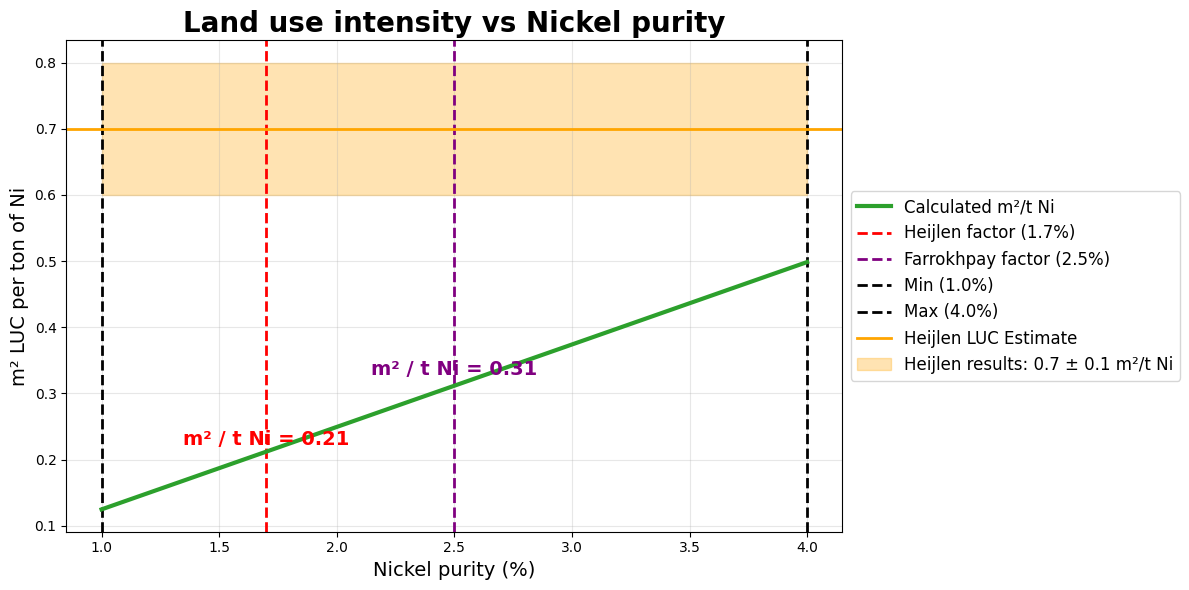

In [194]:
def plot_m2_per_nickel_vs_purity(pes, m2_per_nickel, report_mean=0.7, report_err=0.1, heijlen=0.017, farrokhpay=0.025, figsize=(12,6)):
    pes = np.array(pes)*100
    m2_per_nickel = np.array(m2_per_nickel)

    fig, ax = plt.subplots(figsize=figsize)

    # Plot the calculated points
    ax.plot(pes, m2_per_nickel, marker='', lw=3, color='tab:green', label='Calculated m²/t Ni', zorder=10)

    # Dotted vertical lines for Heijlen and Farrokhpay
    ax.axvline(heijlen*100, color='red', ls='--', lw=2, label=f'Heijlen factor ({heijlen*100:.1f}%)')
    ax.axvline(farrokhpay*100, color='purple', ls='--', lw=2, label=f'Farrokhpay factor ({farrokhpay*100:.1f}%)')
    ax.axvline(pe_low*100, color='black', ls='--', lw=2, label=f'Min ({pe_low*100}%)')
    ax.axvline(pe_high*100, color='black', ls='--', lw=2, label=f'Max ({pe_high*100}%)')

    # Labels for Heijlen and Farrokhpay points
    heijlen_val = m2_per_nickel[np.argmin(np.abs(pes - heijlen*100))]
    farrokhpay_val = m2_per_nickel[np.argmin(np.abs(pes - farrokhpay*100))]
    ax.text(heijlen*100, heijlen_val*1.05, f'm² / t Ni = {heijlen_val:.2f}', color='red', ha='center', zorder=10, fontsize=14, fontweight='bold')
    ax.text(farrokhpay*100, farrokhpay_val*1.05, f'm² / t Ni = {farrokhpay_val:.2f}', color='purple', ha='center', zorder=10, fontsize=14, fontweight='bold')

    # Shaded region for report value
    ax.axhline(report_mean, color='orange', ls='-', lw=2, label='Heijlen LUC Estimate')
    ax.fill_between([pes.min(), pes.max()], report_mean - report_err, report_mean + report_err, color='orange', alpha=0.3, label='Heijlen results: 0.7 ± 0.1 m²/t Ni')

    # Labels, title, grid
    ax.set_xlabel('Nickel purity (%)', fontsize=14)
    ax.set_ylabel('m² LUC per ton of Ni', fontsize=14)
    ax.set_title('Land use intensity vs Nickel purity', fontsize=20, fontweight='bold')
    ax.grid(alpha=0.3)

    # Legend and layout
    ax.legend(frameon=True, fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

plot_m2_per_nickel_vs_purity(pes, m2_per_nickel)

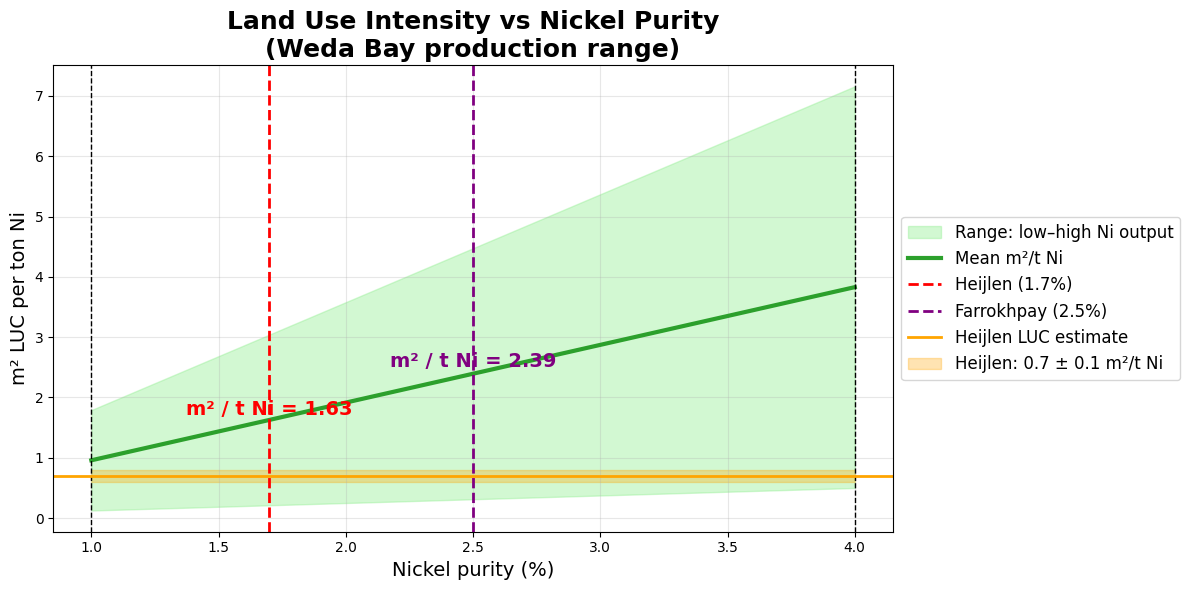

In [ ]:
# --- Existing setup ---
weda_bay_yrly_ni_output_low = 36000
weda_bay_yrly_ni_output_high = 517000  # tonnes Ni

# --- Compute ore output factors for both low and high Ni production ---
ore_output_low = [weda_bay_yrly_ni_output_low / pe / recovery_factor for pe in pes]
ore_output_high = [weda_bay_yrly_ni_output_high / pe / recovery_factor for pe in pes]

mean_cleared_land_per_year = cleared_stats[difference_ever_cleared_col].mean()

# --- m² per tonne Ni for low and high ---
m2_per_nickel_low = mean_cleared_land_per_year / np.array(ore_output_high)  # higher Ni output → less land per tonne
m2_per_nickel_high = mean_cleared_land_per_year / np.array(ore_output_low)  # lower Ni output → more land per tonne
m2_per_nickel_mean = (m2_per_nickel_low + m2_per_nickel_high) / 2

def plot_m2_per_nickel_vs_purity(pes, m2_low, m2_high, m2_mean,
                                 report_mean=0.7, report_err=0.1,
                                 heijlen=0.017, farrokhpay=0.025,
                                 figsize=(12,6)):
    pes = np.array(pes) * 100

    fig, ax = plt.subplots(figsize=figsize)

    # Shaded range between low/high
    ax.fill_between(pes, m2_low, m2_high, color='lightgreen', alpha=0.4,
                    label='Range: low–high Ni output')

    # Mean line
    ax.plot(pes, m2_mean, color='tab:green', lw=3, label='Mean m²/t Ni')

    # Reference lines
    ax.axvline(heijlen*100, color='red', ls='--', lw=2, label=f'Heijlen ({heijlen*100:.1f}%)')
    ax.axvline(farrokhpay*100, color='purple', ls='--', lw=2, label=f'Farrokhpay ({farrokhpay*100:.1f}%)')
    ax.axvline(pe_low*100, color='black', ls='--', lw=1)
    ax.axvline(pe_high*100, color='black', ls='--', lw=1)

    # Report range
    ax.axhline(report_mean, color='orange', ls='-', lw=2, label='Heijlen LUC estimate')
    ax.fill_between([pes.min(), pes.max()],
                    report_mean - report_err, report_mean + report_err,
                    color='orange', alpha=0.3, label='Heijlen: 0.7 ± 0.1 m²/t Ni')
    
    # Labels for Heijlen and Farrokhpay points
    heijlen_val = m2_per_nickel_mean[np.argmin(np.abs(pes - heijlen*100))]
    farrokhpay_val = m2_per_nickel_mean[np.argmin(np.abs(pes - farrokhpay*100))]
    ax.text(heijlen*100, heijlen_val*1.05, f'm² / t Ni = {heijlen_val:.2f}', color='red', ha='center', zorder=10, fontsize=14, fontweight='bold')
    ax.text(farrokhpay*100, farrokhpay_val*1.05, f'm² / t Ni = {farrokhpay_val:.2f}', color='purple', ha='center', zorder=10, fontsize=14, fontweight='bold')

    # Labels
    ax.set_xlabel('Nickel purity (%)', fontsize=14)
    ax.set_ylabel('m² LUC per ton Ni', fontsize=14)
    ax.set_title('Land Use Intensity vs Nickel Purity\n(Weda Bay production range)', fontsize=18, fontweight='bold')
    ax.grid(alpha=0.3)

    ax.legend(frameon=True, fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()


# --- Run ---
plot_m2_per_nickel_vs_purity(pes, m2_per_nickel_low, m2_per_nickel_high, m2_per_nickel_mean)
